# Linear model for classification
In regression, we saw that the target to be predicted was a continuous
variable. In classification, this target will be discrete (e.g. categorical).

We will go back to our penguin dataset. However, this time we will try to
predict the penguin species using the culmen information. We will also
simplify our classification problem by selecting only 2 of the penguin
species to solve a binary classification problem.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [7]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins_classification.csv")

# only keep the Adelie and Chinstrap classes
penguins = penguins.set_index("Species").loc[
    ["Adelie", "Chinstrap"]].reset_index()
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

We can quickly start by visualizing the feature distribution by class:

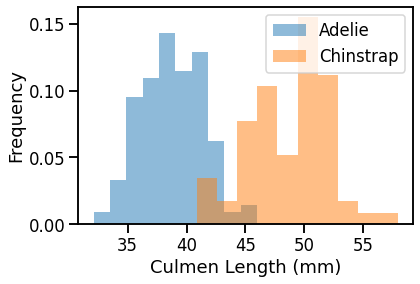

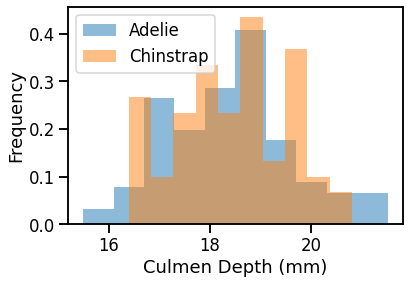

In [8]:
import matplotlib.pyplot as plt

for feature_name in culmen_columns:
    plt.figure()
    # plot the histogram for each specie
    penguins.groupby("Species")[feature_name].plot.hist(
        alpha=0.5, density=True, legend=True)
    plt.xlabel(feature_name)

We can observe that we have quite a simple problem. When the culmen
length increases, the probability that the penguin is a Chinstrap is closer
to 1. However, the culmen depth is not helpful for predicting the penguin
species.

For model fitting, we will separate the target from the data and
we will create a training and a testing set.

In [10]:
from sklearn.model_selection import train_test_split

penguins_train, penguins_test = train_test_split(penguins, random_state=0)

data_train = penguins_train[culmen_columns]
data_test = penguins_test[culmen_columns]

target_train = penguins_train[target_column]
target_test = penguins_test[target_column]

range_features = {
    feature_name: (penguins[feature_name].min() - 1,
                   penguins[feature_name].max() + 1)
    for feature_name in culmen_columns
}
range_features

{'Culmen Length (mm)': (31.1, 59.0), 'Culmen Depth (mm)': (14.5, 22.5)}

To visualize the separation found by our classifier, we will define an helper
function `plot_decision_function`. In short, this function will plot the edge
of the decision function, where the probability to be an Adelie or Chinstrap
will be equal (p=0.5).

In [11]:
import numpy as np


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")

    return ax

The linear regression that we previously saw will predict a continuous
output. When the target is a binary outcome, one can use the logistic
function to model the probability. This model is known as logistic
regression.

Scikit-learn provides the class `LogisticRegression` which implements this
algorithm.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="none")
)
logistic_regression.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(penalty='none'))])

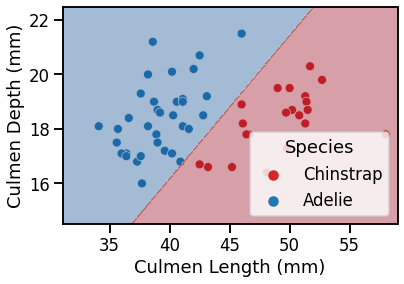

In [13]:
import seaborn as sns

ax = sns.scatterplot(
    data=penguins_test, x=culmen_columns[0], y=culmen_columns[1],
    hue=target_column, palette=["tab:red", "tab:blue"])
_ = plot_decision_function(logistic_regression, range_features, ax=ax)

Thus, we see that our decision function is represented by a line separating
the 2 classes. We should also note that we did not impose any regularization
by setting the parameter `penalty` to `'none'`.

Since the line is oblique, it means that we used a combination of both
features:

In [14]:
coefs = logistic_regression[-1].coef_[0]  # the coefficients is a 2d array
weights = pd.Series(coefs, index=culmen_columns)

Text(0.5, 1.0, 'Weights of the logistic regression')

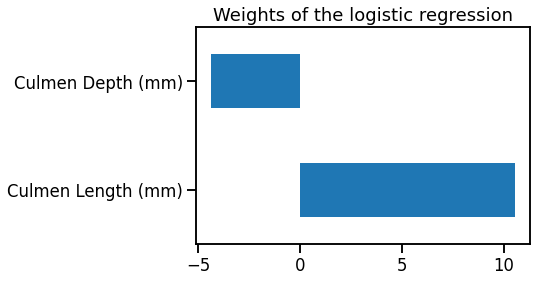

In [15]:
weights.plot.barh()
plt.title("Weights of the logistic regression")

Indeed, both coefficients are non-null.